<a href="https://colab.research.google.com/github/rahmanabidchy/Object-detection/blob/master/Object_detection_tf2_model_zoo_from_Webcam_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 25kB/s 
     |████████████████████████████████| 3.0MB 54.9MB/s 
     |████████████████████████████████| 460kB 51.3MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2232, done.
remote: Counting objects: 100% (2232/2232), done.
remote: Compressing objects: 100% (1930/1930), done.
remote: Total 2232 (delta 539), reused 939 (delta 277), pack-reused 0
Receiving objects: 100% (2232/2232), 30.48 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1580418 sha256=079994e4bb07225ca302f1d061e97103d99c7cc2cbbfa59e3cd006fd7c16ec79
  Stored in directory: /tmp/pip-ephem-wheel-cache-fzr332hn/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.0-cp36-none-any.whl size=43735 sha256=ceb35d6adc39a332997dbae68737ebbd62d880a19b687130fd94daac2f2c8bd9
  Stored in directory: /root/.cache/pip/wheels/3f/15/cd/fe4ec8b88c130393464703ee8111e2cddebdc40e1b59ea85e9
  Created wheel for oauth2client: filename=oauth2client-3.0.0-cp36-none-any.whl size=106382 sha256=91a2b91763130e3c36269cf336ada623c809c629e8f26dbd79a318186de60c1c
  Stored in directory: /root/.cache/pip/wheels/48/f7/87/b932f09c6335dbcf45d916937105a372ab14f353a9ca431d7d
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=6678c34724dd29dfde3ca5a276e78b1108e3380a1

ERROR: pydrive 1.3.1 has requirement oauth2client>=4.0.0, but you'll have oauth2client 3.0.0 which is incompatible.
ERROR: multiprocess 0.70.10 has requirement dill>=0.3.2, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.24.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


In [4]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [6]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8.tar.gz
!tar -xf centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8.tar.gz
!mv centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8/ models/research/object_detection/test_data/

--2020-10-09 04:59:11--  http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.218.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207436086 (198M) [application/x-tar]
Saving to: ‘centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8.tar.gz’

centernet_resnet50_ 100%[===================>] 197.83M   118MB/s    in 1.7s    

2020-10-09 04:59:13 (118 MB/s) - ‘centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8.tar.gz’ saved [207436086/207436086]



In [7]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('models/research/object_detection/test_data/centernet_resnet50_v1_fpn_512x512_kpts_coco17_tpu-8/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 14.590082168579102s


Elapsed time: 4.10210919380188 second per image


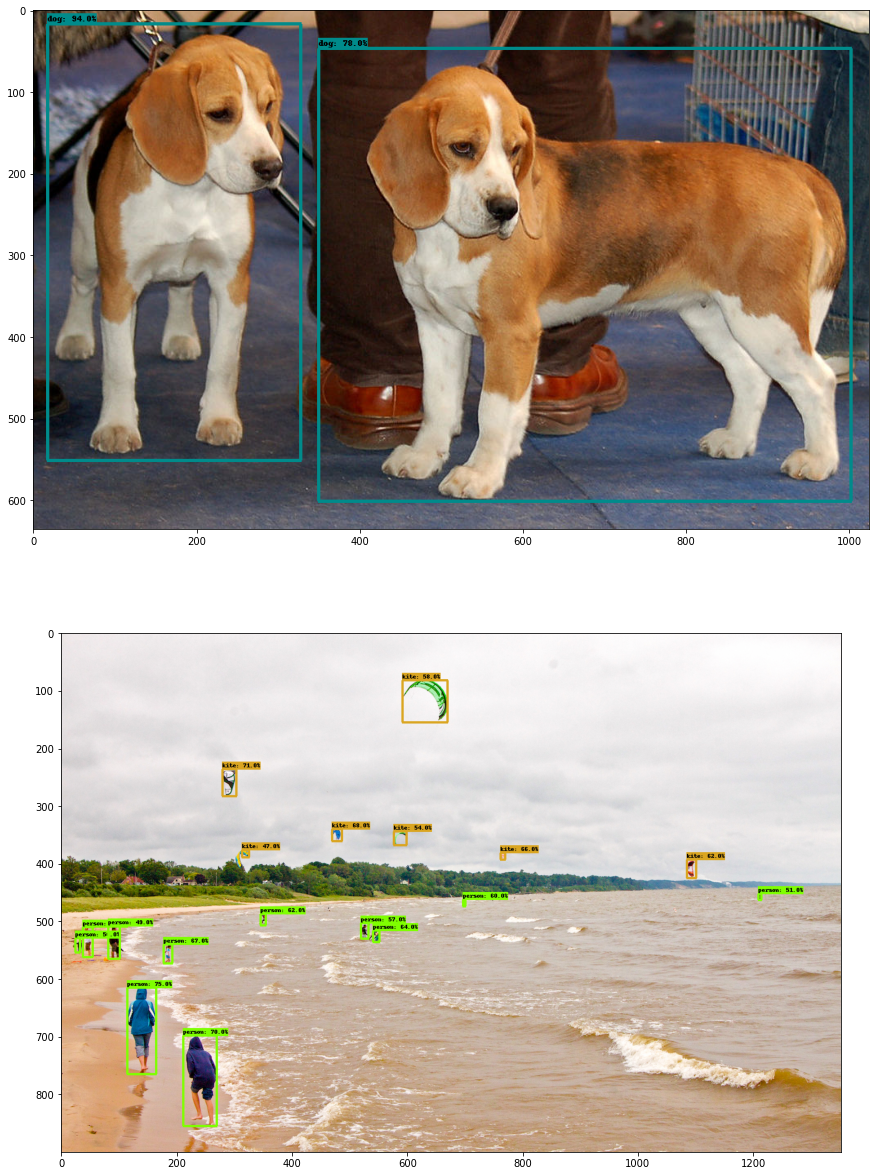

In [8]:
import time

image_dir = 'models/research/object_detection/test_images'

elapsed = []
for i in range(2):
  image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

## Utility functions for taking webcam input

Here we'll have the javascript utility functions that will help us take input from the webcam.

In [9]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [10]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    (im_width, im_height) = image_PIL.size
    image_array = np.array(image_PIL)

    return np.array(image_array).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


def drawing_array_to_bytes(drawing_array):
    """
    input: 
          drawing_array: image RGB size 512 x 512 
                              contain bounding box and text from the prediction, 
                              channel A value = 255 if the pixel contains drawing properties (lines, text) 
                              else channel A value = 0

    output: 
          drawing_bytes: string, encoded from drawing_array
    """

    drawing_PIL = Image.fromarray(drawing_array, 'RGB')
    iobuf = io.BytesIO()
    drawing_PIL.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

## Doing the inference and Visualizing result

To do the inference we just need to call our TF Hub loaded model.

In [11]:
#Taking webcam input
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
while True:
    js_reply = take_photo(label_html, img_data)
    if not js_reply:
        break

    image_np = js_reply_to_image(js_reply) 
    
    # running inference ```````
    results = detect_fn(image_np)
    # different object detection models have additional results
    result = {key:value.numpy() for key,value in results.items()}
    label_id_offset = 0

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    if 'detection_keypoints' in result:
      keypoints = result['detection_keypoints'][0]
      keypoint_scores = result['detection_keypoint_scores'][0]

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np[0],
          result['detection_boxes'][0],
          (result['detection_classes'][0] + label_id_offset).astype(int),
          result['detection_scores'][0],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False,
          keypoints=keypoints,
          keypoint_scores=keypoint_scores,
          )
    #``````````````````````````

    img_data = drawing_array_to_bytes(image_np[0]) #this function converts the np to byte


<IPython.core.display.Javascript object>